# Markowitz portfolio using CAC40 data

[Markowitz portfolio](#markowitz)

[Maximum Sharpe ratio portfolio](#msr)

[Global Minimum Variance portfolio](#gmv)

In [2]:
from finance_utils import annualize_rets, portfolio_return, portfolio_vol

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

---

In [3]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')
df_cac40_rets = df_cac40.pct_change().dropna() # drop 1st line containing NaNs

df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')
df_cac40_stocks_rets = df_cac40_stocks.pct_change().dropna()

# annualized data
rets = annualize_rets(df_cac40_stocks_rets, 252)
cov = df_cac40_stocks_rets.cov()

---

## Markowitz portfolio  <a id='markowitz'></a>

Considering returns are known, the Markowitz portfolio weights are given by minimizing portfolio volatility for any value of portfolio return.

$$\textbf{w} = \arg\min_w \frac{1}{2}\textbf{w}^T\Sigma\textbf{w}$$
subject to: $\textbf{w}^T.\textbf{r}=r_{\text{portfolio}}$, $\textbf{w}^T.\textbf{1}=1$, $w>0$ (no shorting). $\Sigma$ is the covariance matrix, and the 1/2 factor is added in order to have a quadratic form.

$\textbf{r}$ is the vector of annualized returns and $r_{\text{portfolio}}$ is the portfolio return.

##### Minimize volatility

Find the set of weights that minimize the output of the `portfolio_vol(weights, cov)`

In [4]:
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # each of the n weights is in [0.0; 1.0]
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x


Weights minimizing the variance for a return of 0.15, given historical returns and covariance

In [5]:
minimize_vol(0.15, rets, cov)

array([3.23313502e-02, 8.78881386e-18, 9.32413868e-18, 0.00000000e+00,
       2.79182059e-18, 7.48099499e-18, 0.00000000e+00, 0.00000000e+00,
       4.87199825e-02, 0.00000000e+00, 1.01372903e-17, 0.00000000e+00,
       2.65043864e-02, 9.62229428e-19, 0.00000000e+00, 1.16760812e-01,
       0.00000000e+00, 0.00000000e+00, 1.26736805e-02, 2.08031292e-18,
       0.00000000e+00, 3.91943259e-01, 0.00000000e+00, 1.30104261e-18,
       9.60196549e-18, 0.00000000e+00, 0.00000000e+00, 1.07842026e-01,
       2.43945489e-18, 0.00000000e+00, 6.23416249e-19, 0.00000000e+00,
       0.00000000e+00, 1.85302400e-01, 7.79221041e-02, 0.00000000e+00,
       1.61275073e-18, 8.94466792e-19, 0.00000000e+00, 4.74338450e-18])

##### Plot efficient frontier

Spanning `n_points` equally spaced returns accross all returns values in expected returns `er`, minimize the volatility using Markowitz portfolio calculation `minimize_vol()`

In [6]:
def optimal_weights(n_points, er, cov):
    """
    Find optimal weights for a given set of returns and a covariance matrix
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')


<Axes: xlabel='Volatility'>

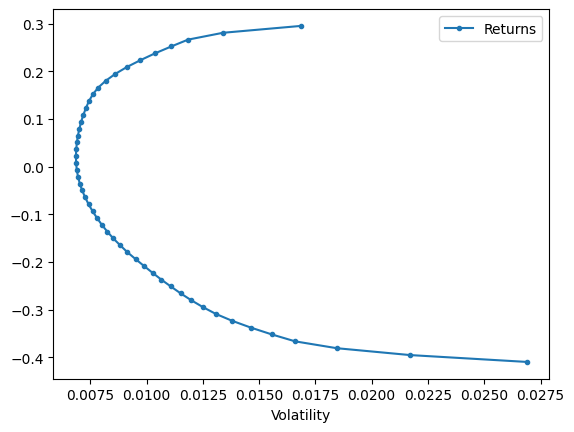

In [7]:
plot_ef(50, rets, cov)

## Maximum Sharpe ratio portfolio <a id='msr'></a>

Portfolio Sharpe ratio measures return over risk using annualized quantities:
$$\lambda=\frac{r_{portfolio} - r_{riskfree}}{\sigma_{portfolio}}$$ 

Writing $\textbf{r}$ as the vector of annualized returns for each assets, $\textbf{w}$ the vector of weights for each asset, and $\Sigma$ the covariace matrix, we have:

$$r_{portfolio}=\textbf{w}^T.\textbf{r}$$
$$\sigma_{portfolio}=\sqrt{\textbf{w}^T\Sigma\textbf{w}}$$

The **maximum Sharpe ratio portfolio** is given by the set of weights $\textbf{w}$ that minimize $-\lambda$.

In [8]:
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    
    er = annualized returns for each asset of the portfolio
    cov = covariance matrix between the returns of each asset
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # each of the n weights is in [0.0; 1.0]
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    # minimize the negative Sharpe ratio
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x


Plotting the MSR portfolio on the efficient frontier

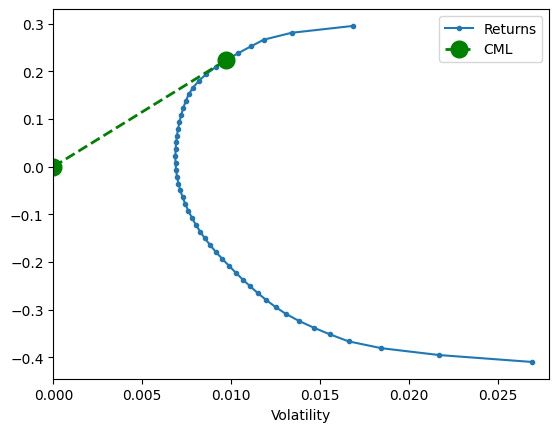

In [9]:
# plot EF
ax = plot_ef(50, rets, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.0
w_msr = msr(rf, rets, cov)
r_msr = portfolio_return(w_msr, rets)
vol_msr = portfolio_vol(w_msr, cov)
# add Capital Market Line = loci of portfolios consisting of MSR and safe asset
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = 'CML')
ax.legend()

## Global Minimum Variance portfolio <a id='gmv'></a>


GMV is the portfolio of lowest volatility on the efficient frontier.

GMV is calculated by using the optimizer of the max Sharpe ratio portfolio, where all weights are set equal. 

=> The optimizer cannot improve the Sharpe ratio through raising returns, and so it must do so by lowering volatility

In [10]:
def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    # parameters of msr:
    # riskfree_rate = 0 bacause it's not going to get used anyway
    # weights = np.repeat(1,n) : put equal weights everywhere so that optimization is done only on the cov matrix
    return msr(0, np.repeat(1, n), cov)

In [11]:
w_gmv = gmv(cov)

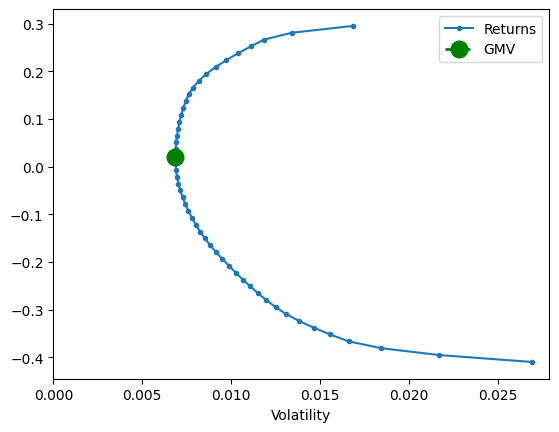

In [12]:
# plot EF
ax = plot_ef(50, rets, cov)
ax.set_xlim(left = 0)
# get GMV
r_gmv = portfolio_return(w_gmv, rets)
vol_gmv = portfolio_vol(w_gmv, cov)

gmv_x = [vol_gmv]
gmv_y = [r_gmv]
ax.plot(gmv_x, gmv_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = 'GMV')
ax.legend()